In [1]:
import pandas as pd
from sklearn.datasets import make_classification
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR']= '/content'

In [5]:
!kaggle datasets download -d sharveshtsrinivasan/cardiaccc

Dataset URL: https://www.kaggle.com/datasets/sharveshtsrinivasan/cardiaccc
License(s): unknown
100% 2.16G/2.16G [01:28<00:00, 25.1MB/s]
100% 2.16G/2.16G [01:28<00:00, 26.1MB/s]


In [6]:
!unzip /content/cardiaccc.zip -d /content/cardiaccc

Streaming output truncated to the last 5000 lines.
  inflating: /content/cardiaccc/cardiomegaly_images(1) (1)/00006481_010.png  
  inflating: /content/cardiaccc/cardiomegaly_images(1) (1)/00006481_012.png  
  inflating: /content/cardiaccc/cardiomegaly_images(1) (1)/00006481_013.png  
  inflating: /content/cardiaccc/cardiomegaly_images(1) (1)/00006481_014.png  
  inflating: /content/cardiaccc/cardiomegaly_images(1) (1)/00006481_015.png  
  inflating: /content/cardiaccc/cardiomegaly_images(1) (1)/00006481_018.png  
  inflating: /content/cardiaccc/cardiomegaly_images(1) (1)/00006481_022.png  
  inflating: /content/cardiaccc/cardiomegaly_images(1) (1)/00006481_023.png  
  inflating: /content/cardiaccc/cardiomegaly_images(1) (1)/00006481_025.png  
  inflating: /content/cardiaccc/cardiomegaly_images(1) (1)/00006481_030.png  
  inflating: /content/cardiaccc/cardiomegaly_images(1) (1)/00006481_031.png  
  inflating: /content/cardiaccc/cardiomegaly_images(1) (1)/00006481_032.png  
  inflating: 

In [7]:
import os
import pandas as pd
from fastai.vision.all import *
from fastai.vision import models
from fastai.metrics import error_rate, accuracy

import warnings
warnings.filterwarnings("ignore")
set_seed(42)

print ('modules loaded')


modules loaded


In [9]:
!pip install fastai
from fastai.vision.all import *

path = '/content/cardiaccc'

data = ImageDataLoaders.from_folder(
    path,
    train='.',
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(224),
)


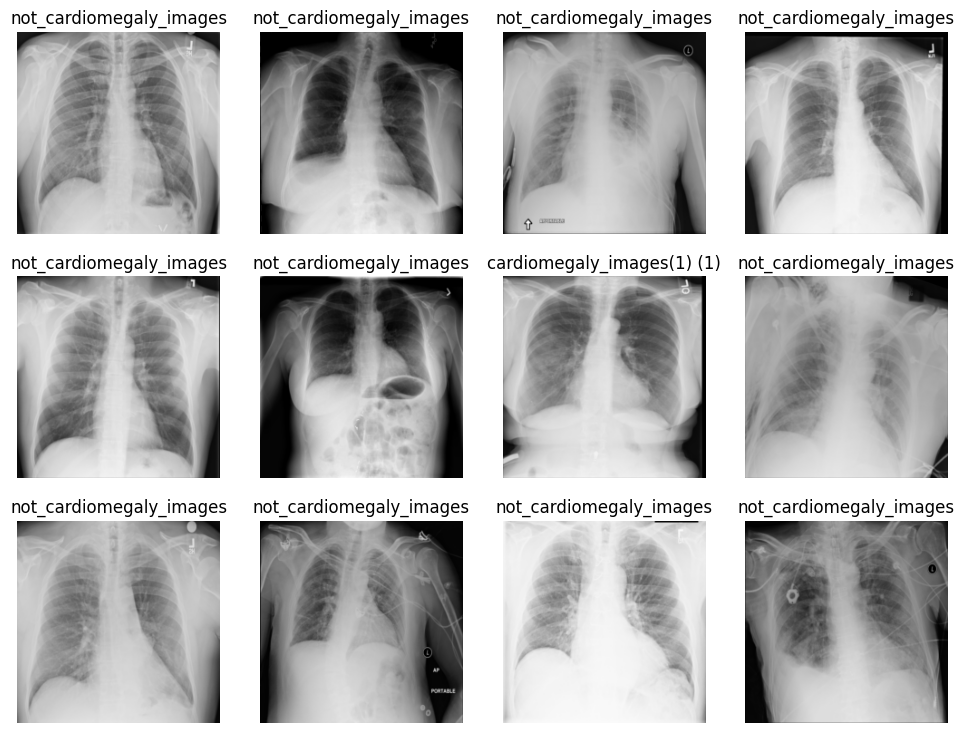

In [11]:
data.show_batch(max_n=12)

In [12]:
total_images = len(get_image_files(path))
print(f'Total number of images: {total_images}')

Total number of images: 5797


In [15]:
!pip install split-folders


In [16]:
import splitfolders  # To split dataset
import os

# Path to your dataset folder
input_folder = '/content/cardiaccc'

# Output folder for the split data (train, val, test)
output_folder = '/content/split_dataset'

# Split the dataset into train (70%), val (15%), and test (15%)
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.7, 0.15, 0.15), group_prefix=None)

print("Dataset split completed!")


Copying files: 5797 files [00:25, 228.59 files/s]

Dataset split completed!


In [17]:
import os

# Define paths for train, test, and val directories
train_dir = '/content/split_dataset/train'
val_dir = '/content/split_dataset/val'
test_dir = '/content/split_dataset/test'

# Function to get file paths for each class in train, val, and test directories
def get_image_paths(directory):
    image_paths = []
    class_labels = []

    # Loop over each class folder (e.g., cardiomegaly_images, not_cardiomegaly_images)
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            # Get all image file paths in the class folder
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                if file_name.endswith(('.png', '.jpg', '.jpeg')):  # Adjust file types if needed
                    image_paths.append(file_path)
                    class_labels.append(class_name)

    return image_paths, class_labels

# Get paths and labels for train, val, and test sets
train_paths, train_labels = get_image_paths(train_dir)
val_paths, val_labels = get_image_paths(val_dir)
test_paths, test_labels = get_image_paths(test_dir)

# Display the number of images and first few file paths for verification
print(f"Number of training images: {len(train_paths)}")
print(f"Number of validation images: {len(val_paths)}")
print(f"Number of test images: {len(test_paths)}")

# Optionally, view first few image paths
print("Sample training image paths:", train_paths[:5])
print("Sample validation image paths:", val_paths[:5])
print("Sample test image paths:", test_paths[:5])


Number of training images: 4057
Number of validation images: 869
Number of test images: 871
Sample training image paths: ['/content/split_dataset/train/cardiomegaly_images(1) (1)/00005878_001.png', '/content/split_dataset/train/cardiomegaly_images(1) (1)/00004342_015.png', '/content/split_dataset/train/cardiomegaly_images(1) (1)/00000013_029.png', '/content/split_dataset/train/cardiomegaly_images(1) (1)/00002497_001.png', '/content/split_dataset/train/cardiomegaly_images(1) (1)/00004461_019.png']
Sample validation image paths: ['/content/split_dataset/val/cardiomegaly_images(1) (1)/00007858_004.png', '/content/split_dataset/val/cardiomegaly_images(1) (1)/00003610_015.png', '/content/split_dataset/val/cardiomegaly_images(1) (1)/00005038_000.png', '/content/split_dataset/val/cardiomegaly_images(1) (1)/00002763_033.png', '/content/split_dataset/val/cardiomegaly_images(1) (1)/00001330_000.png']
Sample test image paths: ['/content/split_dataset/test/cardiomegaly_images(1) (1)/00003395_006.p

In [20]:
data_dir = '/content/split_dataset/train'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
df.head()

,filepaths,labels
0,/content/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1040-0001.jpeg,NORMAL
1,/content/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0460-0001.jpeg,NORMAL
2,/content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0525-0001-0001.jpeg,NORMAL
3,/content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0231-0001.jpeg,NORMAL
4,/content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0467-0001.jpeg,NORMAL


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   vertical_flip = True,
                                   validation_split=0.25)

base_path = data_dir
target_size = (224,224,3)
data_generator = datagen.flow_from_directory(base_path, target_size=target_size[:2],
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=False)

Found 4057 images belonging to 2 classes.


In [22]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [23]:
features = []
labels = []
image_paths = []

for inputs_batch, labels_batch in data_generator:
    features_batch = feature_extractor.predict(preprocess_input(inputs_batch))
    features.append(features_batch)
    labels.append(labels_batch)
    image_paths.extend(data_generator.filepaths[data_generator.batch_index * data_generator.batch_size : (data_generator.batch_index + 1) * data_generator.batch_size])
    if len(features) * 32 >= data_generator.samples:
        break

features = np.vstack(features)
labels = np.vstack(labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6

In [24]:
labels_flat = np.argmax(labels, axis=1)


In [25]:
np.save('features.npy', features)
np.save('labels.npy', labels)

In [29]:
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import shutil

In [30]:
smote = SMOTE(random_state=42)  # Initialize SMOTE
features_resampled, labels_resampled = smote.fit_resample(features, labels_flat)  # Apply SMOTE

new_var = len(features_resampled) # Now features_resampled is defined
new_var

6724

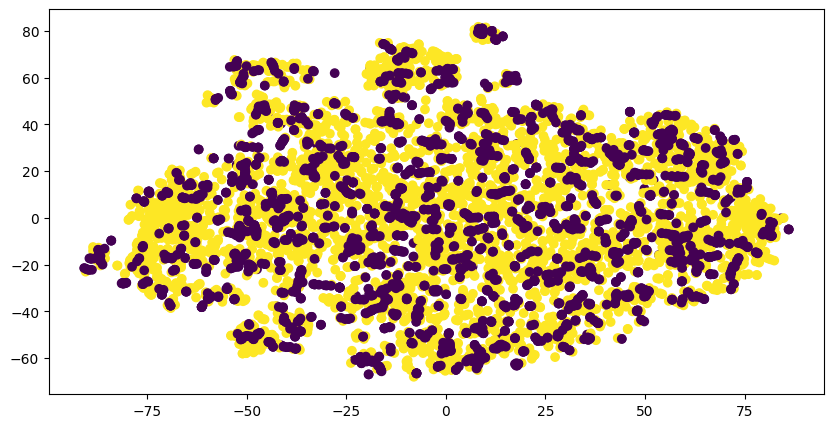

In [34]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to reduce dimensionality to 2
tsne = TSNE(n_components=2, random_state=42)
features_embedded = tsne.fit_transform(features_resampled)

# Visualize the embedded features
plt.figure(figsize=(10, 5))
# Since labels_resampled is already 1-dimensional (not one-hot encoded),
# we don't need to use argmax. We can directly use it for plotting.
plt.scatter(features_embedded[:, 0], features_embedded[:, 1], c=labels_resampled)
plt.show()

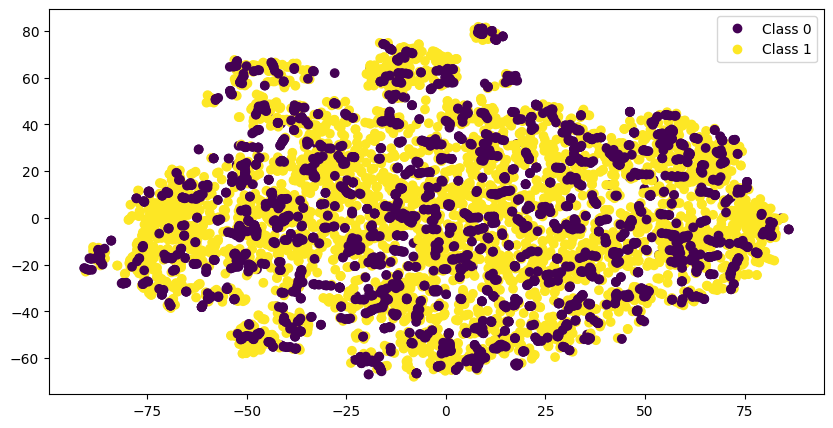

In [36]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


tsne = TSNE(n_components=2, random_state=42)
features_embedded = tsne.fit_transform(features_resampled)

plt.figure(figsize=(10, 5))

# labels_resampled is already 1-dimensional and likely represents the class labels directly.
# Removing the argmax call as it's unnecessary and causing the error.
# labels_resampled_flat = np.argmax(labels_resampled, axis=1)
# Instead, use labels_resampled directly:

scatter = plt.scatter(features_embedded[:, 0], features_embedded[:, 1], c=labels_resampled)


plt.legend(handles=scatter.legend_elements()[0], labels=[f"Class {i}" for i in range(len(np.unique(labels_resampled)))])

plt.show()

Load SMOTE images

In [37]:
smote = SMOTE(random_state=42)
features_resampled, labels_resampled = smote.fit_resample(features, labels_flat)

num_classes = data_generator.num_classes
labels_resampled = to_categorical(labels_resampled, num_classes=num_classes)

original_indices = np.arange(len(features))
resampled_indices = smote.fit_resample(original_indices.reshape(-1, 1), labels_flat)[0].flatten()

save_dir = '/content/gdrive/MyDrive/smote_Images'
os.makedirs(save_dir, exist_ok=True)



In [38]:
import cv2

In [39]:
import os
import cv2
import pandas as pd
from tensorflow.keras.utils import to_categorical

# Function to save images into label-specific folders
def save_images_by_label(image_paths, resampled_indices, labels, save_dir):
    # Ensure the base directory exists
    os.makedirs(save_dir, exist_ok=True)

    resampled_image_paths = []

    for idx, original_idx in enumerate(resampled_indices):
        # Determine the label of the image
        label = np.argmax(labels[idx])

        # Create a directory for this label if it doesn't already exist
        label_dir = os.path.join(save_dir, str(label))
        os.makedirs(label_dir, exist_ok=True)

        # Read the image
        original_image_path = image_paths[original_idx]
        image = cv2.imread(original_image_path)

        # Define the new image path
        resampled_image_name = f'resampled_image_{idx}.jpg'
        resampled_image_path = os.path.join(label_dir, resampled_image_name)

        # Save the image
        cv2.imwrite(resampled_image_path, image)

        # Append the new image path to the list
        resampled_image_paths.append(resampled_image_path)

    return resampled_image_paths

# Path to save resampled images and labels
save_dir = '/content/saved_images'

# Save the resampled images into label-specific folders
resampled_image_paths = save_images_by_label(image_paths, resampled_indices, labels_resampled, save_dir)

# Save labels to a CSV file along with image paths
labels_df = pd.DataFrame({
    'image_path': resampled_image_paths,
    'label': np.argmax(labels_resampled, axis=1)  # Converting one-hot labels to categorical
})
labels_df.to_csv(os.path.join(save_dir, 'labels_resampled.csv'), index=False)

print(f'Resampled images and labels saved to {save_dir}')


Resampled images and labels saved to /content/saved_images


In [40]:
classes = ['CM','NCM']

In [59]:
classes = ['CM','NCM']
smote_data_dir = '/content/saved_images'
filepaths = []
labels = []

folds = os.listdir(smote_data_dir)
for fold in folds:
    # Check if the current item is a directory before proceeding
    if os.path.isdir(os.path.join(smote_data_dir, fold)):
        if fold=='0':
            folder_name = "NON CARDIOMEGALY"
        elif fold=="1":
            folder_name = "CARDIOMEGALY"
        else:
            pass
        foldpath = os.path.join(smote_data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(folder_name)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
smot_df = pd.concat([Fseries, Lseries], axis= 1)

In [60]:
smot_df.shape

(6724, 2)

In [61]:
smot_df.head()

,filepaths,labels
0,/content/saved_images/0/resampled_image_4782.jpg,NON CARDIOMEGALY
1,/content/saved_images/0/resampled_image_5724.jpg,NON CARDIOMEGALY
2,/content/saved_images/0/resampled_image_5900.jpg,NON CARDIOMEGALY
3,/content/saved_images/0/resampled_image_4247.jpg,NON CARDIOMEGALY
4,/content/saved_images/0/resampled_image_6325.jpg,NON CARDIOMEGALY


In [64]:
save_images_path = "/content/drive/MyDrive/Datasets/sample_synthetic_data"

import os
import shutil




if not os.path.exists(save_images_path):
    os.makedirs(save_images_path)


grouped = smot_df.groupby('labels')


for label, group in grouped:

    label_folder = os.path.join(save_images_path, label)
    if not os.path.exists(label_folder):
        os.makedirs(label_folder)


    files_to_copy = group['filepaths'].head(20)

    for filepath in files_to_copy:

        filename = os.path.basename(filepath)

        destination = os.path.join(label_folder, filename)

        shutil.copy(filepath, destination)

In [65]:
df.head()

,filepaths,labels
0,/content/split_dataset/train/cardiomegaly_images(1) (1)/00005878_001.png,cardiomegaly_images(1) (1)
1,/content/split_dataset/train/cardiomegaly_images(1) (1)/00004342_015.png,cardiomegaly_images(1) (1)
2,/content/split_dataset/train/cardiomegaly_images(1) (1)/00000013_029.png,cardiomegaly_images(1) (1)
3,/content/split_dataset/train/cardiomegaly_images(1) (1)/00002497_001.png,cardiomegaly_images(1) (1)
4,/content/split_dataset/train/cardiomegaly_images(1) (1)/00004461_019.png,cardiomegaly_images(1) (1)


In [66]:
def plot_dataframe(df):
  class_counts = df['labels'].value_counts().sort_index()
  # Plotting the bar chart
  plt.figure(figsize=(8, 6))
  plt.bar(class_counts.index, class_counts.values, tick_label=class_counts.index)

  # Adding labels and title
  plt.xlabel('Class')
  plt.ylabel('Number of Samples')
  plt.title('Number of Samples for Each Class')

  # Display the plot
  plt.show()

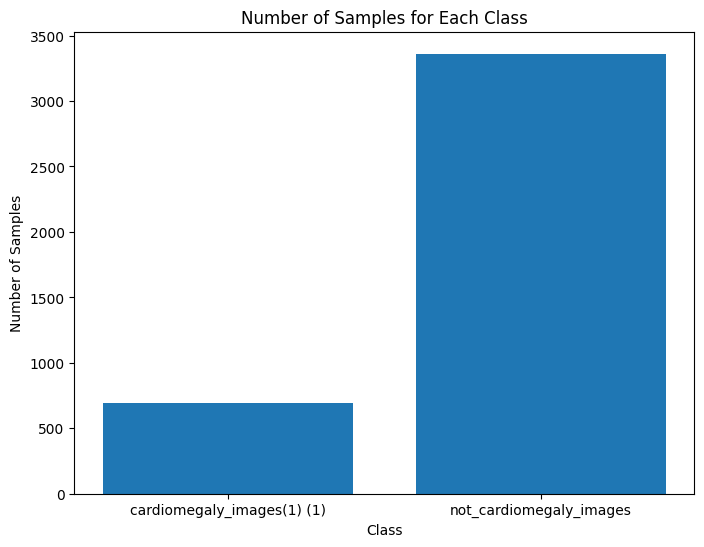

In [67]:
plot_dataframe(df)

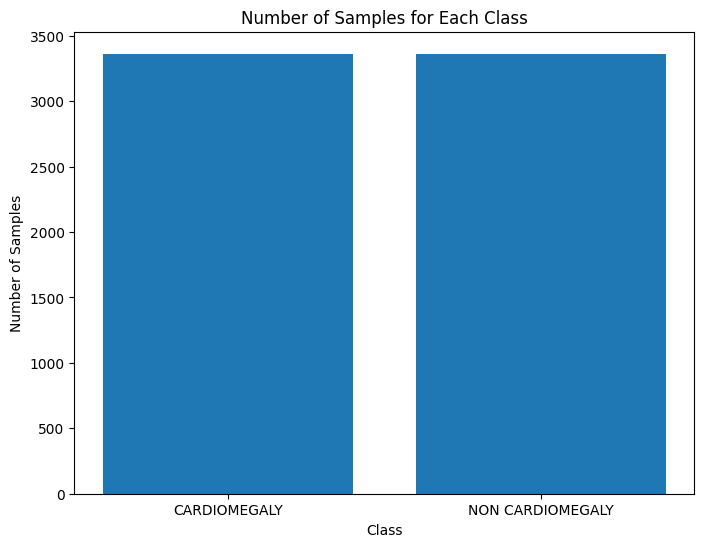

In [68]:
plot_dataframe(smot_df)

# Comparison between synthetic and original datset


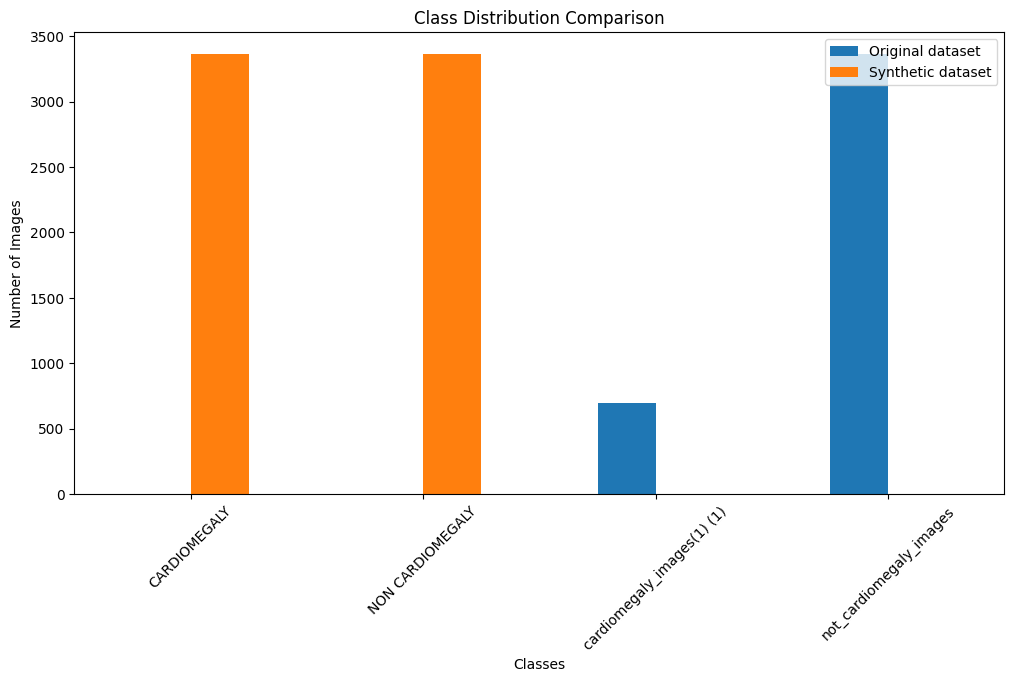

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count class occurrences
class_dist1 = df['labels'].value_counts().sort_index()
class_dist2 = smot_df['labels'].value_counts().sort_index()

# Create a DataFrame for easier plotting
comparison_df = pd.DataFrame({
    'Original dataset': class_dist1,
    'Synthetic dataset': class_dist2
})

# Plotting the class distributions
comparison_df.plot(kind='bar', figsize=(12, 6))
plt.title('Class Distribution Comparison')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [70]:
import matplotlib.image as mpimg

def show_sample_images(df, title, n=5):
    plt.figure(figsize=(n*3, 10))
    plt.suptitle(title, fontsize=20)

    # Sample n images per class
    for i, label in enumerate(df['labels'].unique()):
        sample_images = df[df['labels'] == label].sample(n)
        for j, filepath in enumerate(sample_images['filepaths']):
            ax = plt.subplot(len(df['labels'].unique()), n, i*n + j + 1)
            img = mpimg.imread(filepath)
            plt.imshow(img)
            plt.title(label)
            plt.axis('off')
    plt.show()



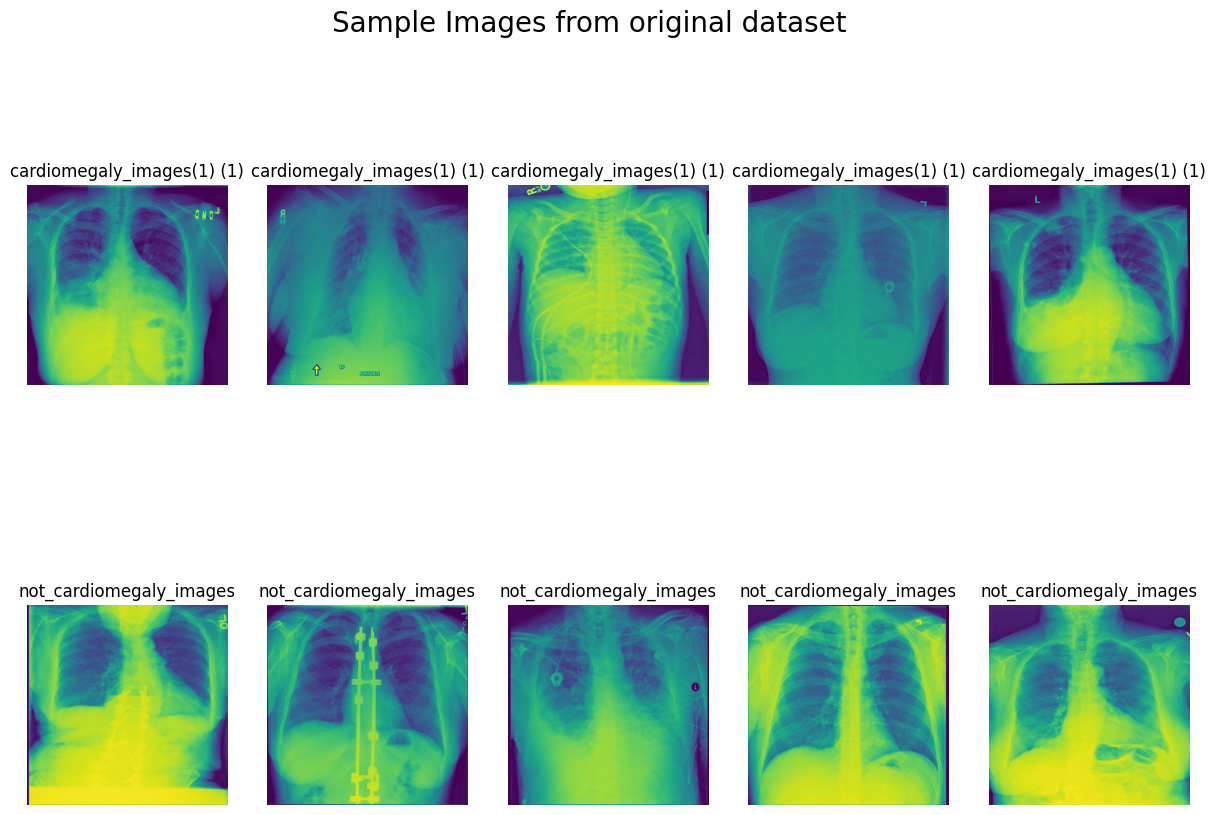

In [71]:

show_sample_images(df, "Sample Images from original dataset")


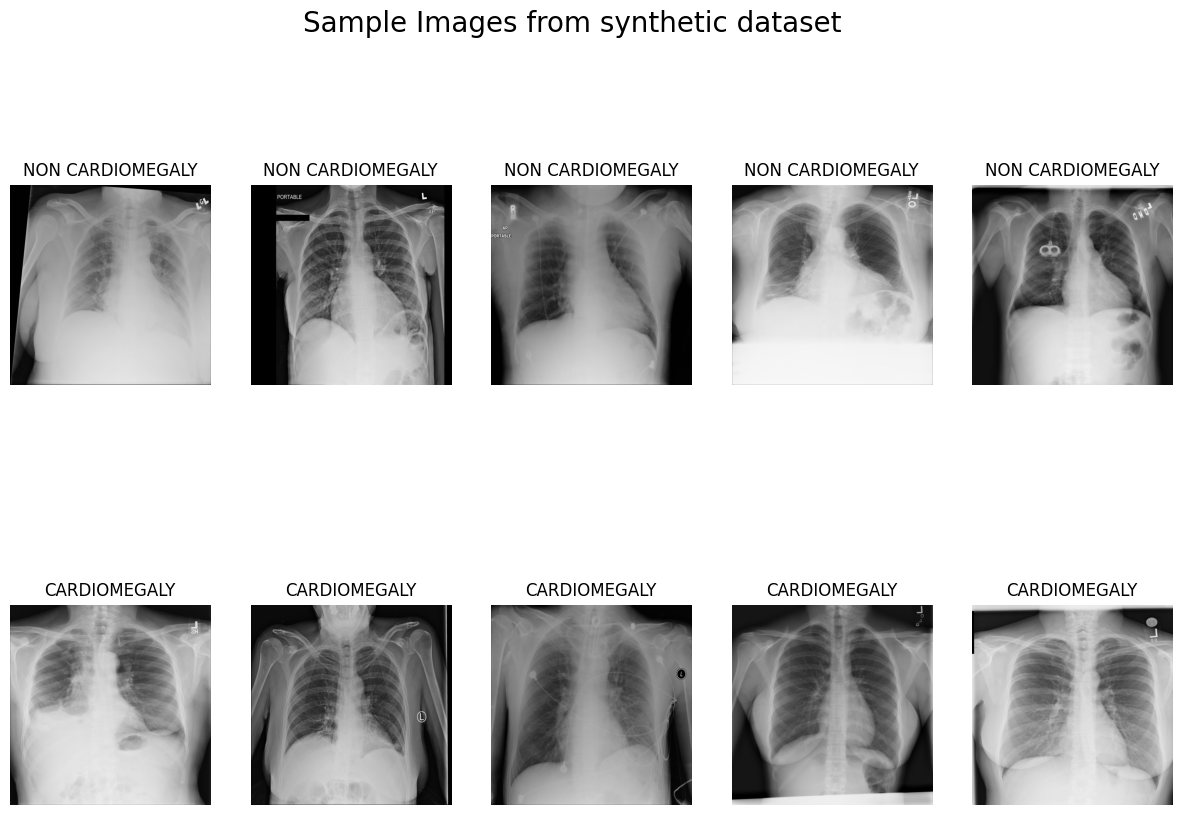

In [72]:
show_sample_images(smot_df, "Sample Images from synthetic dataset")

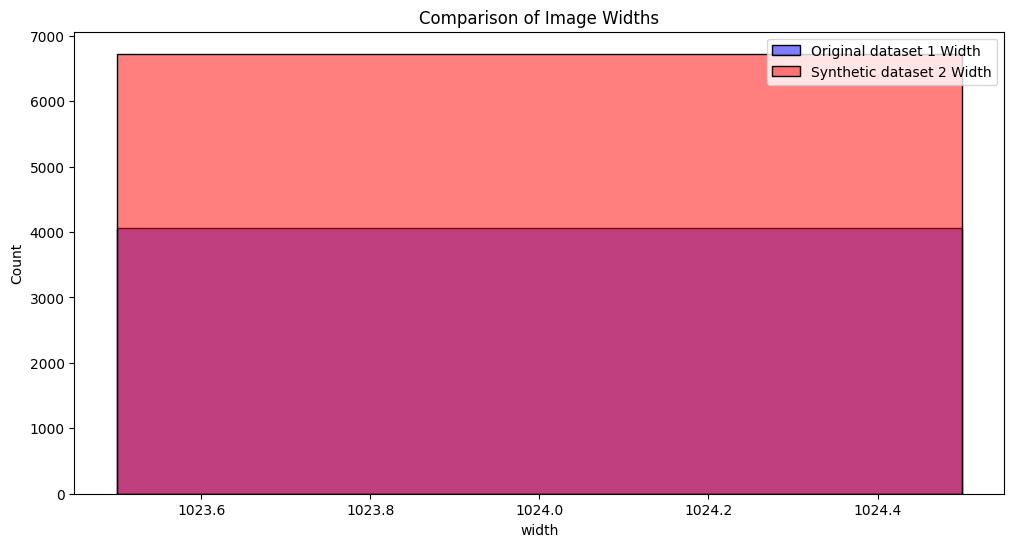

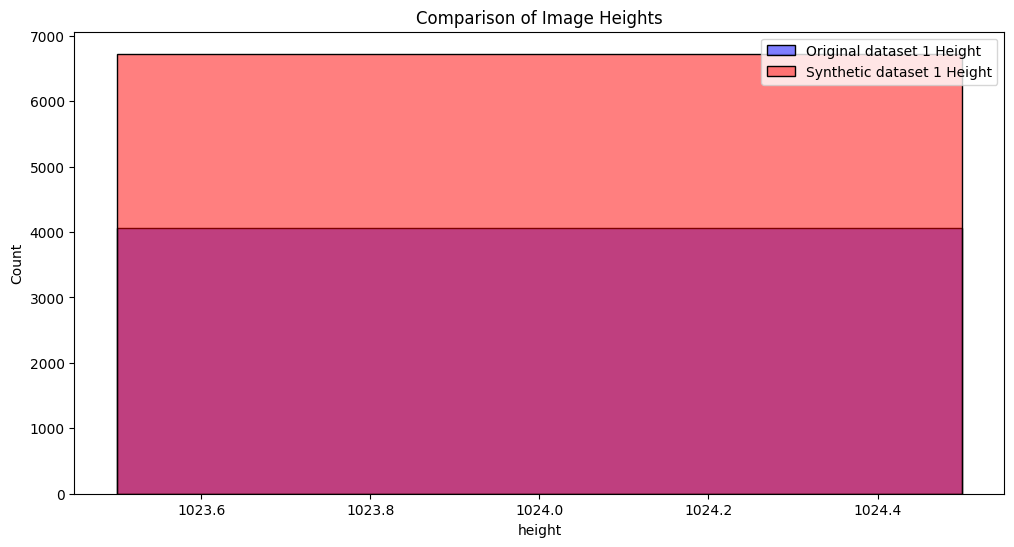

In [74]:
from PIL import Image

def get_image_dimensions(df):
    sizes = []
    for filepath in df['filepaths']:
        with Image.open(filepath) as img:
            sizes.append(img.size)
    return sizes


sizes1 = get_image_dimensions(df)
sizes2 = get_image_dimensions(smot_df)


sizes_df1 = pd.DataFrame(sizes1, columns=['width', 'height'])
sizes_df2 = pd.DataFrame(sizes2, columns=['width', 'height'])


plt.figure(figsize=(12, 6))
sns.histplot(sizes_df1['width'], color='blue', label='Original dataset 1 Width', kde=True)
sns.histplot(sizes_df2['width'], color='red', label='Synthetic dataset 2 Width', kde=True)
plt.title('Comparison of Image Widths')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(sizes_df1['height'], color='blue', label='Original dataset 1 Height', kde=True)
sns.histplot(sizes_df2['height'], color='red', label='Synthetic dataset 1 Height', kde=True)
plt.title('Comparison of Image Heights')
plt.legend()
plt.show()